## Measuring distances to the PAL5 globular cluster

Author: Luke Bischoff<br>
Created: 03 DEC 2020<br>
Last updated: 04 DEC 2020

##### Introduction
This notebook aims to find distances to RR Lyrae variable stars in the Palomar 5 globular cluster using images from the 3.6μm and 4.5μm filters of the Spitzer Space Telescope. The process is outlined here:<br>
1) identifying sources in both filters to generate a master source list from a mosaic image of both filters<br>
2) performing photometry across all 12 time epochs available, either via using aperture photometry techniques or using PSF photometry to obtain apparent magnitudes of the sources identified in the epoch frames<br>
3) these stars will then be matched with the master source list to give a common ID number to make searching for the RR Lyrae (RRL) stars easier<br>
4) identification of the RRLs by cross-referencing to Gaia sources and a catalogue of variable stars created by Christine Clement will initially be used. Attempts to calculate the period of each RRL will be undertaken here too<br>
5) light curves will be constructed and analysed using GLOESS code to fit curves to the light curve data<br>
6) PL relations will be fit using the data, this will finally enable distances to be obtained<br>

##### Import list

In [2]:
import math
import glob
import copy
import numpy as np
import pandas as pd
import astroalign as aa
import matplotlib
import matplotlib.pyplot as plt
from astropy import wcs
from astropy import units as u
from astropy.io import fits # used for FITS file management
from astropy.io import ascii
from astropy.time import Time
from astropy.stats import sigma_clipped_stats # used within star detection
from astropy.table import Table, join
from astropy.nddata import NDData
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.coordinates import Angle
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from photutils import aperture_photometry # used to perform photometry using annuli
from photutils import DAOStarFinder # used for the star finding algorithm
from photutils import CircularAperture, CircularAnnulus
from photutils import EPSFBuilder
from photutils.psf import extract_stars
from photutils.psf import DAOGroup
from photutils.psf import IterativelySubtractedPSFPhotometry
from photutils.background import MMMBackground
from matplotlib.colors import LogNorm

##### User defined functions

In [3]:
## COORDINATE CONVERSION ##
def Coord_Conv(header, x_list, y_list):
    # CONVERTS COORDINATES IN X, Y TO RIGHT ASCENSION AND DECLINATION USING ICRS COORDINATES
    # header: INPUT HEADER REFERENCE TO OBTAIN WCS
    # x_list, y_list: LIST OF X AND Y COORDINATES TO BE CONVERTED
    w = wcs.WCS(header)
    coord = np.transpose((x_list, y_list))
    world = w.wcs_pix2world(coord, 0)
    ra, dec = world[:, 0], world[:, 1]
    c = SkyCoord(ra, dec, frame = 'icrs', unit = 'deg')
    return ra, dec, c

##### Initialisation and options

In [54]:
## INPUT DATA PATHS ##

cluster_input = 'PAL5'

if cluster_input == 'PAL5':
    epoch_path = 'PAL5_data/*/'
    master_path = 'PAL5_data/PAL5/'
    general_path = 'PAL5_data/'
elif cluster_input == 'PAL13':
    epoch_path = 'PAL13_data/*/'
    master_path = 'PAL13_data/PAL13/'
    general_path = 'PAL13_data/'
elif cluster_input == 'IC4499':
    epoch_path = 'IC4499_data/*/'
    master_path = 'IC4499_data/IC4499/'
    general_path = 'IC4499_data/'
else:
    raise ValueError('Cluster not found: input clusters `PAL5`, `PAL13` or `IC4499` only!')

## CHANNEL ##

channel = '3p6um'

if channel == '3p6um':
    aper_corr = 1.1233            # aperture correction for 337 (6,6,14) apertures in channel 1, c.f IRAC handbook §4.10
    ap_err    = aper_corr * 0.02  # uncertainty to ~2% as per IRAC handbook
    zmag      = 18.80             # zeropoint magnitude given in IRAC handbook §4.8
    zmag_err  = 0.02              # uncertainty calculated from F0 = 280.9 +/- 4.1 in IRAC handbook
elif channel == '4p5um':
    aper_corr = 1.1336
    ap_err    = aper_corr * 0.02
    zmag      = 18.32
    zmag_err  = 0.02
else:
    raise ValueError('Incorrect channel input: only values 3p6um or 4p5um permitted.')
    
## PARAMETERS AND OPTIONS ##

fwhm = 5.
sigma = 6.
sigma_epsf = 50.
r_ap = 6.
r_in = 6.
r_out = 14.
roundlo = -0.5
roundhi = +0.5
sharphi = 0.9
sharphi_model = 0.8

phot_method = 'psf'     # SELECT PHOTOMETRY METHOD: 'aperture' or 'psf'

##### Master source list

FITS file information:
FILE = PAL5_data/PAL5/PAL5_3p6um.fits



Number of ePSF sources found = 119

Number of refined ePSF sources = 90



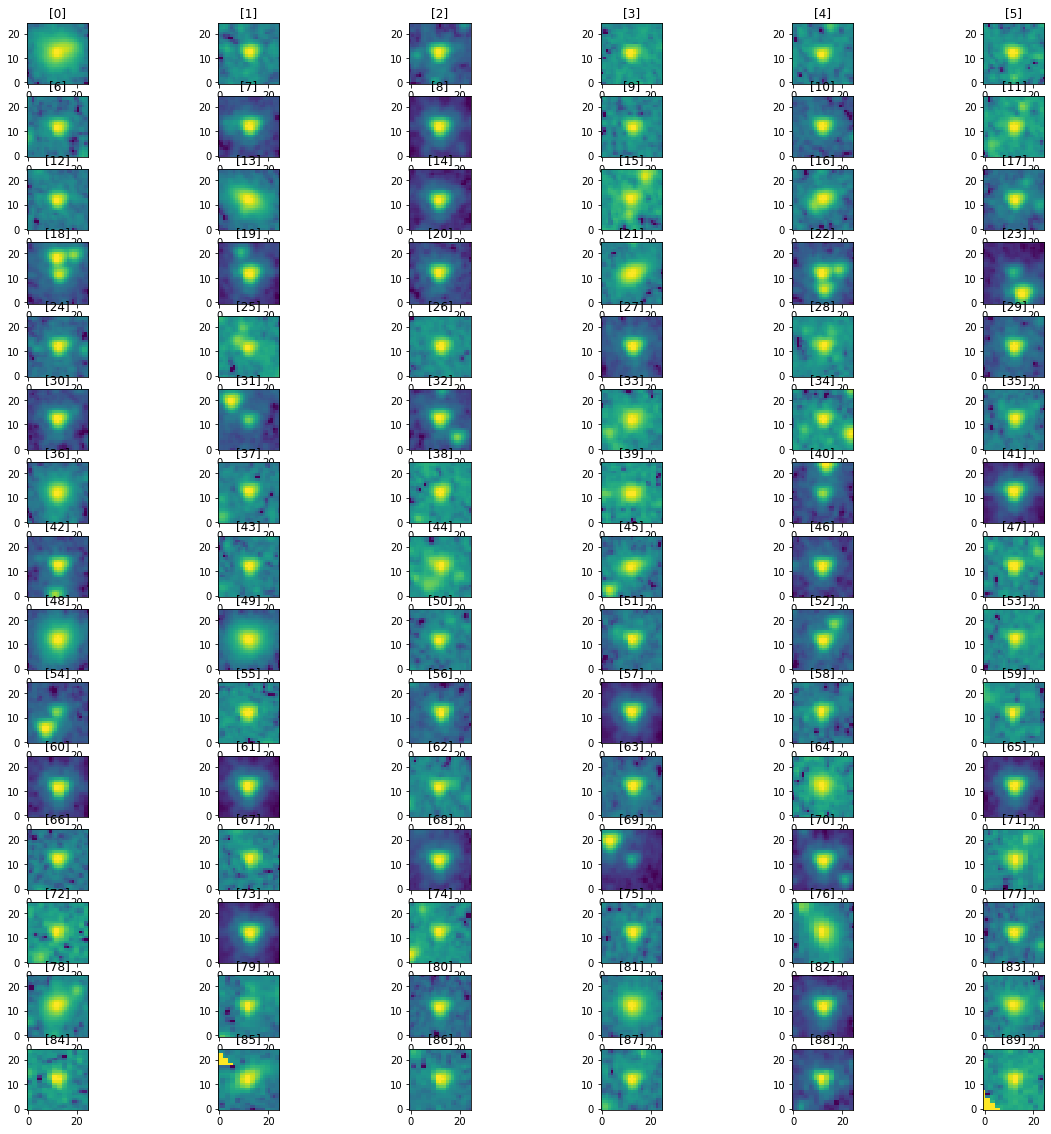

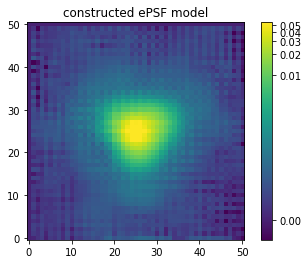

Remove any poor quality model stars from the model by their ID. Use ID -99 to escape
85 89


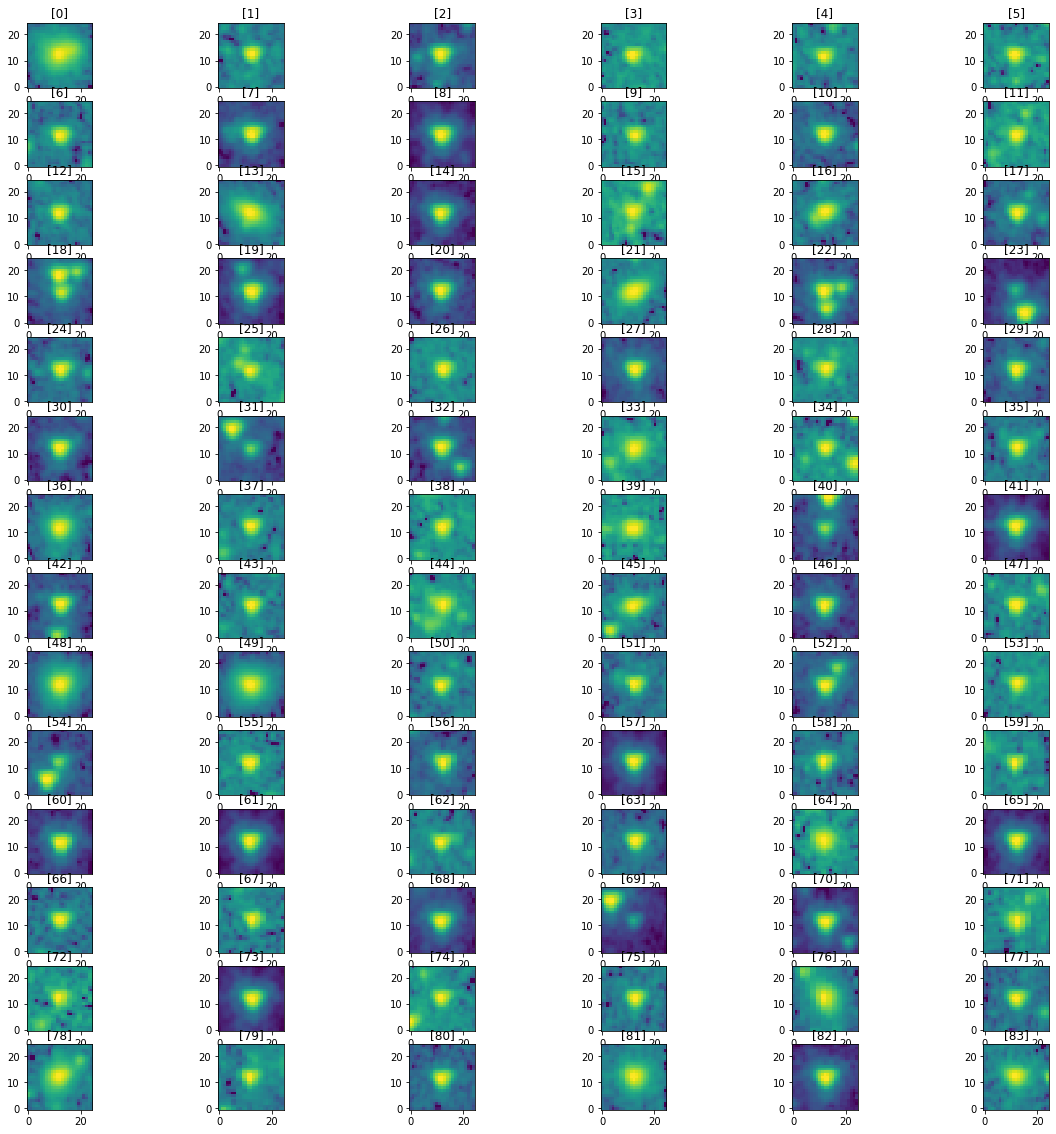

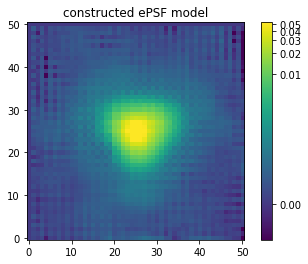

Remove any poor quality model stars from the model by their ID. Use ID -99 to escape
-99
Escape completed



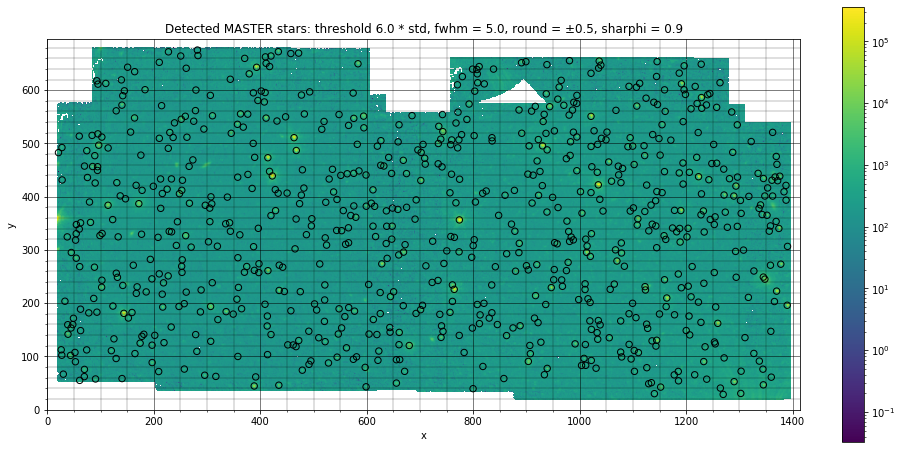

Number of MASTER stars detected = 790



Number of MASTER stars found from PSF = 863



idx,master_id,x_0,y_0,ra,dec
0,0,1269.5063258483376,28.576868985369124,229.0630315162843,-0.15644268282020193
1,1,1302.5323577023107,30.41383225609205,229.06184132896902,-0.1618256156510142
2,2,1264.2161506278433,40.4727125768036,229.0612170509874,-0.15525266063353485
3,3,1290.0140281406764,52.5272481938853,229.05854056184526,-0.1591719271799346
4,4,1303.1593044119372,72.16214529776158,229.0549574145943,-0.16080619010700592
5,5,1140.2739672278392,29.994285687889022,229.0662732722692,-0.1351476171842811
6,6,1152.0517082774918,42.328688459734956,229.06392773476134,-0.1367532412693178
7,7,1129.5421224473064,48.674351148967304,229.06348921167694,-0.13288009487872435
8,8,1134.6013478827433,50.59324768540729,229.06303754176184,-0.1336606723589888
9,9,1102.806752375499,71.8541829705888,229.06039531392366,-0.12785921655373947


In [7]:
## BUILDING MASTER SOURCE LIST USING MOSAICKED IMAGE ##

master_file = master_path+cluster_input+'_'+channel+'.fits'

## OPENING FITS FILE AND EXTRACTING DATA ##

with fits.open(master_file) as hdr_list:
    m_hdr = hdr_list[0].header
    counts = m_hdr['EXPTIME'] / m_hdr['FLUXCONV']
    im_data = fits.getdata(master_file, ext = 0)
    m_data = im_data * counts
    print('FITS file information:\nFILE = {0}\n'.format(master_file))

## BUILDING ePSF FOR MASTER FILE ##

mean_epsf, median_epsf, std_epsf = sigma_clipped_stats(m_data, sigma = sigma) # sigma-clipping on data

starfind_init = DAOStarFinder(fwhm = fwhm, threshold = sigma_epsf * std_epsf, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi_model)
epsf_sources = starfind_init(m_data)
print('Number of ePSF sources found = {0}\n'.format(len(epsf_sources)))

## STAR CUTOUTS FOR ePSF ##

cutout_size = 200
hsize = (cutout_size - 1) / 2
x = epsf_sources['xcentroid']
y = epsf_sources['ycentroid']
mask = ((x > hsize) & (x < (m_data.shape[1] - 1 - hsize)) &
        (y > hsize) & (y < (m_data.shape[0] - 1 - hsize)))

star_tbl = Table()       # build table of star sources
star_tbl['x'] = x[mask]
star_tbl['y'] = y[mask]
star_tbl['id'] = range(len(star_tbl))
print('Number of refined ePSF sources = {0}\n'.format(len(star_tbl)))

## EXTRACT STARS ##

epsf_data = m_data - median_epsf
while True:
    nddata = NDData(data = epsf_data)
    epsf_stars = extract_stars(nddata, star_tbl, size = 25)

    ## VISUALISE MODEL STARS ##
    ncols = 6
    nrows = int(np.floor(len(epsf_stars) / ncols))
    remaining = len(epsf_stars) - ncols * nrows

    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20), squeeze = True)
    ax = ax.ravel()
    for i in range(nrows * ncols):
        norm = simple_norm(epsf_stars[i], 'log', percent = 99.)
        ax[i].imshow(epsf_stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
        ax[i].set_title([i])
    plt.show()
    for i in range(ncols * nrows, len(epsf_stars)):
        norm = simple_norm(epsf_stars[i], 'log', percent = 99.)
        ax[i - ncols * nrows].imshow(epsf_stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
        ax[i - ncols * nrows].set_title([i])
    plt.show()
    plt.close()
    
    ## BUILD ePSF ##

    epsf_builder = EPSFBuilder(oversampling = 2, maxiters = 10, progress_bar = True)
    epsf, fitter = epsf_builder(epsf_stars)
    
    norm = simple_norm(epsf.data, 'log', percent = 99.)
    plt.imshow(epsf.data, cmap = 'viridis', norm = norm, origin = 'lower')
    plt.title('constructed ePSF model')
    plt.colorbar()
    plt.show()
    
    print('Remove any poor quality model stars from the model by their ID. Use ID -99 to escape')
    remove = [int(k) for k in input().split()]
    
    if remove == [-99]:
        print('Escape completed\n')
        break
    
    star_tbl.add_index('id')
    bad_id = star_tbl.loc_indices[remove]
    star_tbl.remove_rows(bad_id)

    
## SOURCE DETECTION ##

mean_m, median_m, std_m = sigma_clipped_stats(m_data, sigma = sigma)

master_daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma * std_m, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi)
master_sources = master_daofind(m_data)

# PLOT INITIAL DETECTED SOURCES
master_positions = np.transpose((master_sources['xcentroid'], master_sources['ycentroid']))
master_apertures = CircularAperture(master_positions, r = r_ap)

plt.imshow(m_data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
master_apertures.plot(color = 'black', lw = 1.)
plt.colorbar(fraction = 0.05)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Detected MASTER stars: threshold {0} * std, fwhm = {1}, round = ±{2}, sharphi = {3}'
          .format(sigma, fwhm, roundhi, sharphi))
plt.minorticks_on()
plt.grid(b = True, which = 'major', lw = .5, color = 'black')
plt.grid(b = True, which = 'minor', lw = .25, color = 'black')
plt.gcf().set_size_inches(15, 8)
plt.show()
plt.close()
print('Number of MASTER stars detected = {0}\n'.format(len(master_sources)))

## RENAME STAR LIST HEADERS ##

master_sources['xcentroid'].name = 'x_0'
master_sources['ycentroid'].name = 'y_0'
master_sources['id'].name = 'master_id'

## PSF ROUTINE ON MASTER LIST ##

daogroup = DAOGroup(crit_separation = sigma * fwhm)

data_psf_m = np.nan_to_num(m_data, nan = 1**-7)

epsf.x_0.fixed = True
epsf.y_0.fixed = True
pos_init_m = Table(names = ['x_0', 'y_0'], data = [master_sources['x_0'], master_sources['y_0']])

PSF_photometry = IterativelySubtractedPSFPhotometry(finder = master_daofind,
                                                    group_maker = daogroup,
                                                    bkg_estimator = MMMBackground(),
                                                    psf_model = epsf,
                                                    fitter = LevMarLSQFitter(),
                                                    niters = 2,
                                                    aperture_radius = r_ap,
                                                    fitshape = (11, 11))

m_phot = PSF_photometry(image = data_psf_m, init_guesses = pos_init_m)
residual_image = PSF_photometry.get_residual_image()

print('Number of MASTER stars found from PSF = {0}\n'.format(len(m_phot)))

## COORDINATE CONVERSION ##

master_list = copy.copy(m_phot)
del master_list['flux_0', 'group_id', 'x_fit', 'y_fit', 'flux_fit', 'flux_unc', 'iter_detected']
master_list['id'].name = 'phot_id'

master_list['master_id'] = int(0)
for i in range(len(master_list)):
    master_list['master_id'][i] = i
    
del master_list['phot_id']
new_order = ['master_id', 'x_0', 'y_0']
master_list = master_list[new_order]

ra_m, dec_m, c_m = Coord_Conv(m_hdr, master_list['x_0'], master_list['y_0'])

master_list['ra'] = ra_m
master_list['dec'] = dec_m

## EXPORT AND SAVE FILE -- SHOW IN NOTEBOOK ##

master_list.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\{0}_master_list_{1}.txt'.format(cluster_input, channel), format = 'csv', overwrite = True)

master_list.show_in_notebook()

##### Photometry on all epochs

In [8]:
## PHOTOMETRY ON EPOCHS ##

## INITIALISE MAIN TABLE ##

main_table = copy.copy(master_list)

## STORE EPOCH TIMES AS MODIFIED JULIAN DATE [MJD] ##

lctime = []

## EPOCH LOOP COUNTER ##

epoch = 0

## PHOTOMETRY LOOP ##

path1 = epoch_path+cluster_input+'__e[0-9]_'+channel+'.fits'
path2 = epoch_path+cluster_input+'__e[0-9][0-9]_'+channel+'.fits'

for file in glob.glob(path1, recursive = True) + glob.glob(path2, recursive = True):
    epoch += 1
    print('EPOCH NUMBER = {0}\n'.format(epoch))
    ## OPENING FITS FILE AND EXTRACTING DATA ##
    with fits.open(file) as hdr_list:
        e_hdr = hdr_list[0].header
        counts = e_hdr['EXPTIME'] / e_hdr['FLUXCONV']
        time = Time(e_hdr['DATE_OBS'])
        
        im_data = fits.getdata(file, ext = 0)
        e_data = im_data * counts
        
        print('FITS file information:\nFILE = {0}\nDATE = {1}\n\n'.format(file, time))
    
    ## EXTRACT TIME FROM EPOCH ##
    
    lctime.append(Time(e_hdr['DATE_OBS'], format = 'isot', scale = 'utc').mjd)
    
    ## EXTRACTING LOC-DEPENDENT CORRECTION ##
    corr_file = general_path+cluster_input+'__e'+str(epoch)+'/'+cluster_input+'__e'+str(epoch)+'_correction_'+channel+'.fits'
    with fits.open(corr_file) as hdu_list:
        corr_data = hdu_list[0].data
    
    mean_psf, median_psf, std_psf = sigma_clipped_stats(e_data, sigma = sigma)

    ## APERTURE PHOTOMETRY LOOP ##
    if phot_method == 'aperture':
        raise ValueError('Incorrect photometry method input! Aperture photometry suspended.')
    
    elif (phot_method == 'psf' or phot_method == 'PSF'):
        ## SOURCE DETECTION ON IMAGE ## 
        psf_daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma * std_psf, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi)
        psf_sources = psf_daofind(e_data)
        print('Number of inital stars detected = {0}\n'.format(len(psf_sources)))
        
        ## GROUP ## 
        psf_sources['xcentroid'].name = 'x_0'
        psf_sources['ycentroid'].name = 'y_0'
        
        daogroup = DAOGroup(crit_separation = sigma * fwhm)
        
        data_psf = np.nan_to_num(e_data, nan = 1**-7)
        
        epsf.x_0.fixed = True
        epsf.y_0.fixed = True
        init_pos = Table(names = ['x_0', 'y_0'], data = [psf_sources['x_0'], psf_sources['y_0']])
        
        ## PERFORMING PSF PHOTOMETRY ##

        PSF_photometry = IterativelySubtractedPSFPhotometry(finder = psf_daofind,
                                                            group_maker = daogroup,
                                                            bkg_estimator = MMMBackground(),
                                                            psf_model = epsf,
                                                            fitter = LevMarLSQFitter(),
                                                            niters = 2,
                                                            aperture_radius = r_ap,
                                                            fitshape = (11, 11))

        result_phot = PSF_photometry(image = data_psf, init_guesses = init_pos)
        residual_image = PSF_photometry.get_residual_image()
        
        print('Number of PSF stars found and analysed = {0}\n'.format(len(result_phot)))
        
        phot = result_phot   # REDEFINE PHOTOMETRY TABLE FOR EASE
        
        PSF_err = phot['flux_unc']
        PSF_flux = phot['flux_fit']
        
        ## APPARENT MAGNITUDES ##
    
        phot['apparent_mag'] = float('NaN')
        for i in range(0, len(phot)):
            # APPLY ARRAY-LOC DEP CORRECTION
            loc_corr = corr_data[int(phot['y_fit'][i])][int(phot['x_fit'][i])]
            if phot['flux_fit'][i] >= 0:
                phot['apparent_mag'][i] = zmag - 2.5 * math.log10(phot['flux_fit'][i] * aper_corr * loc_corr / counts)
        
        ## APPARENT MAGNITUDE: UNCERTAINTIES ##
    
        phot['apparent_mag_unc'] = float('Nan')
        for i in range(0, len(phot)):
            if phot['flux_fit'][i] >= 0:
                phot['apparent_mag_unc'][i] = pow(zmag_err**2 + (2.5*(pow((PSF_err[i] / PSF_flux[i])**2 + (ap_err / aper_corr)**2, 0.5) / (np.log(10)))**2), 0.5)
            
        ## CONVERT COORDINATES ##
        
        ra_e, dec_e, c_e = Coord_Conv(e_hdr, phot['x_fit'], phot['y_fit'])

        phot['ra'] = ra_e
        phot['dec'] = dec_e
        
        ## APPEND APPARENT MAGNITUDE AND UNCERTAINTY COLUMNS FOR EACH EPOCH ##
        
        epoch_table = copy.copy(phot)
        # DELETE CERTAIN COLUMNS TO AVOID CRAMMING NEW EPOCH TABLE
        del epoch_table['x_0', 'y_0', 'flux_0', 'flux_unc', 'iter_detected']
        epoch_mag = 'mag_e'+str(epoch)
        epoch_unc = 'unc_e'+str(epoch)
        epoch_ra = 'ra_epoch'+str(epoch)
        epoch_dec = 'dec_epoch'+str(epoch)
        # RENAME COLUMNS FOR EASE
        epoch_table.rename_column('ra', epoch_ra)
        epoch_table.rename_column('dec', epoch_dec)
        epoch_table.rename_column('apparent_mag', epoch_mag)
        epoch_table.rename_column('apparent_mag_unc', epoch_unc)
        epoch_table.rename_column('x_fit', 'xcenter')
        epoch_table.rename_column('y_fit', 'ycenter')
        
        #epoch_table.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\troubleshooting\e{0}_result_phot_{1}.txt'.format(epoch, channel), format = 'csv', overwrite = True)
        
        ## PHOTOMETRY COMPLETE -- APPARENT MAGNITUDES AND UNCERTAINTIES OBTAINED FOR ALL EPOCHS ##
        
    else:
        raise ValueError('Incorrect photometry method input! Input only value `psf`')
    
    ## MATCH STARS FROM EPOCHS TO MASTER STAR LIST ##
    
    conv_table = copy.copy(main_table)
    
    ra, dec, c = Coord_Conv(e_hdr, epoch_table['xcenter'], epoch_table['ycenter'])

    epoch_table['ra'] = ra
    epoch_table['dec'] = dec
    #epoch_table.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\troubleshooting\e{0}_result_phot_22222_{1}.txt'.format(epoch, channel), format = 'csv', overwrite = True)
    idx, d2d, d3d = c.match_to_catalog_sky(c_m)
    
    # ENSURE MATCHES ARE SIGNIFICANT
    rad = 0.25 * u.arcsec
    selection = (d2d > rad)
    match_index = idx
    match_index[selection] = -99.
    matches = ((match_index >= 0))
    
    epoch_table = epoch_table[matches]
    conv_table = conv_table[match_index][matches]
    
    # ASSIGN EPOCH TABLE ID EQUIVALENT TO MASTER ID
    epoch_table['master_id'] = conv_table['master_id']
    
    epoch_table = Table(epoch_table, masked = True)
    
    main_table = join(main_table, epoch_table['master_id', epoch_mag, epoch_unc], keys = 'master_id', join_type = 'left')
    
    print(main_table)
    
    main_table.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\{0}_interim_phot_epoch{1}_{2}.txt'.format(cluster_input, epoch, channel), format = 'csv', overwrite = True)
    
main_table.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\{0}_main_phot_{1}.txt'.format(cluster_input, channel), format = 'csv', overwrite = True)
main_table.show_in_notebook()

EPOCH NUMBER = 1

FITS file information:
FILE = PAL5_data\PAL5__e1\PAL5__e1_3p6um.fits
DATE = 2013-05-10T21:50:03.531




Number of inital stars detected = 570



Number of PSF stars found and analysed = 660

master_id        x_0         ...       mag_e1              unc_e1       
--------- ------------------ ... ------------------ --------------------
        0 1269.5063258483376 ... 16.732851817422233  0.03892237510547345
        1 1302.5323577023107 ...  16.21958962151448  0.08972868969847365
        2 1264.2161506278433 ...                 --                   --
        3 1290.0140281406764 ... 13.948667046109584  0.02660964052372808
        4 1303.1593044119372 ...                 --                   --
        5 1140.2739672278392 ... 17.273343877528383  0.04597869362487471
        6 1152.0517082774918 ... 15.335283829244093 0.025311604523146538
        7 1129.5421224473064 ... 17.403695799184977  0.05474928280245714
        8 1134.6013478827433 ... 16.357732028380177  0.02996427451585648
        9  1102.806752375499 ...  17.11014852711924   0.0441930358409926
      ...                ... ...                ...                  ...
     

Number of inital stars detected = 563



Number of PSF stars found and analysed = 640

master_id        x_0         ...       mag_e2              unc_e2       
--------- ------------------ ... ------------------ --------------------
        0 1269.5063258483376 ...  16.86829591997125  0.04264670404803581
        1 1302.5323577023107 ... 16.210740011560276  0.11009735475857871
        2 1264.2161506278433 ...                 --                   --
        3 1290.0140281406764 ... 14.078609456186054 0.028492198770035483
        4 1303.1593044119372 ...                 --                   --
        5 1140.2739672278392 ... 17.130117430288013 0.051554824508518414
        6 1152.0517082774918 ... 15.356896490879778 0.025890242649162704
        7 1129.5421224473064 ... 17.301914171403816  0.06301231287208417
        8 1134.6013478827433 ... 16.225516574381828  0.03253167231350193
        9  1102.806752375499 ... 17.084069891041217  0.05012748193804296
      ...                ... ...                ...                  ...
     

Number of inital stars detected = 584



Number of PSF stars found and analysed = 664

master_id        x_0         ...       mag_e3              unc_e3       
--------- ------------------ ... ------------------ --------------------
        0 1269.5063258483376 ... 16.996569560774756  0.05092489691369009
        1 1302.5323577023107 ... 16.168838477206325  0.08461410490494158
        2 1264.2161506278433 ...                 --                   --
        3 1290.0140281406764 ... 14.155964922973272 0.027381105304159936
        4 1303.1593044119372 ...  17.52006321687111  0.26474490073130225
        5 1140.2739672278392 ...  17.05639264196579  0.06695441401133899
        6 1152.0517082774918 ... 15.405126595760276 0.027347990724756695
        7 1129.5421224473064 ... 17.361181173654636  0.08232323052559865
        8 1134.6013478827433 ...  16.34292216900387 0.039490179655976065
        9  1102.806752375499 ...   16.8897275979733 0.059015553876237956
      ...                ... ...                ...                  ...
     

Number of inital stars detected = 577



Number of PSF stars found and analysed = 648

master_id        x_0         ...       mag_e4              unc_e4       
--------- ------------------ ... ------------------ --------------------
        0 1269.5063258483376 ...                 --                   --
        1 1302.5323577023107 ...                 --                   --
        2 1264.2161506278433 ...                 --                   --
        3 1290.0140281406764 ... 14.267574497409479  0.02677239836728297
        4 1303.1593044119372 ...  17.49745769455553   0.1998120163307184
        5 1140.2739672278392 ...                 --                   --
        6 1152.0517082774918 ... 15.379391780985774  0.02706757754829863
        7 1129.5421224473064 ... 17.398313158883486  0.08014805692718548
        8 1134.6013478827433 ... 16.118691542311133 0.034690015017149585
        9  1102.806752375499 ...  16.95233329484947  0.05799036013397139
      ...                ... ...                ...                  ...
     

Number of inital stars detected = 562



Number of PSF stars found and analysed = 637

master_id        x_0         ...       mag_e5              unc_e5      
--------- ------------------ ... ------------------ -------------------
        0 1269.5063258483376 ...                 --                  --
        1 1302.5323577023107 ...                 --                  --
        2 1264.2161506278433 ...                 --                  --
        3 1290.0140281406764 ... 14.341100920176938 0.03113921189713202
        4 1303.1593044119372 ...                 --                  --
        5 1140.2739672278392 ...  17.24385041355791  0.0722577753812116
        6 1152.0517082774918 ... 15.410217591846628 0.02721499321759815
        7 1129.5421224473064 ...                 --                  --
        8 1134.6013478827433 ... 16.207306076238897 0.03459098053042649
        9  1102.806752375499 ... 17.167444115447044 0.06383587800582267
      ...                ... ...                ...                 ...
      852  85.4941

Number of inital stars detected = 544



Number of PSF stars found and analysed = 616

master_id        x_0         ...       mag_e6              unc_e6       
--------- ------------------ ... ------------------ --------------------
        0 1269.5063258483376 ... 16.990121842540596  0.04931468813734767
        1 1302.5323577023107 ...  16.14557409210672  0.05500955380068997
        2 1264.2161506278433 ...                 --                   --
        3 1290.0140281406764 ...  14.14990522172692  0.02547584939459787
        4 1303.1593044119372 ...  17.24580203034389  0.14400214878368597
        5 1140.2739672278392 ... 17.069882163915693  0.08344123740268897
        6 1152.0517082774918 ... 15.361936962124318 0.030079175901430086
        7 1129.5421224473064 ...                 --                   --
        8 1134.6013478827433 ...                 --                   --
        9  1102.806752375499 ...                 --                   --
      ...                ... ...                ...                  ...
     

Number of inital stars detected = 579



Number of PSF stars found and analysed = 670

master_id        x_0         ...       mag_e7              unc_e7       
--------- ------------------ ... ------------------ --------------------
        0 1269.5063258483376 ...                 --                   --
        1 1302.5323577023107 ...                 --                   --
        2 1264.2161506278433 ... 17.523099693071842 0.048785772626855864
        3 1290.0140281406764 ...                 --                   --
        4 1303.1593044119372 ...                 --                   --
        5 1140.2739672278392 ... 17.131243312010334 0.059727822143933657
        6 1152.0517082774918 ... 15.413800946968493 0.026386475777023178
        7 1129.5421224473064 ...                 --                   --
        8 1134.6013478827433 ... 16.148123731939986  0.03255157139874553
        9  1102.806752375499 ...  17.14816789851696 0.059775432916839545
      ...                ... ...                ...                  ...
     

Number of inital stars detected = 560



Number of PSF stars found and analysed = 616

master_id        x_0         ...       mag_e8              unc_e8       
--------- ------------------ ... ------------------ --------------------
        0 1269.5063258483376 ... 16.819559072999432  0.04700019946023588
        1 1302.5323577023107 ...                 --                   --
        2 1264.2161506278433 ...                 --                   --
        3 1290.0140281406764 ... 14.017156553072946   0.0296171586010946
        4 1303.1593044119372 ...                 --                   --
        5 1140.2739672278392 ... 16.941473967836565 0.051997867584602286
        6 1152.0517082774918 ... 15.399646426550428 0.026471756400995583
        7 1129.5421224473064 ...  17.56792448003656  0.08500890079824472
        8 1134.6013478827433 ...  15.96364430278476   0.0306525944372744
        9  1102.806752375499 ...  16.88450936144898  0.05130771977837328
      ...                ... ...                ...                  ...
     

Number of inital stars detected = 539



Number of PSF stars found and analysed = 594

master_id        x_0         ...       mag_e9              unc_e9       
--------- ------------------ ... ------------------ --------------------
        0 1269.5063258483376 ...                 --                   --
        1 1302.5323577023107 ... 16.045027757214797  0.04223049735927722
        2 1264.2161506278433 ... 17.042930189562604  0.04668256678399661
        3 1290.0140281406764 ...                 --                   --
        4 1303.1593044119372 ...                 --                   --
        5 1140.2739672278392 ...  16.90717812329488  0.04625818497217429
        6 1152.0517082774918 ... 15.277236902252389 0.025825926557893047
        7 1129.5421224473064 ...                 --                   --
        8 1134.6013478827433 ... 16.019484009008618  0.02938365258928823
        9  1102.806752375499 ... 17.135860419214843  0.05271104892539974
      ...                ... ...                ...                  ...
     

Number of inital stars detected = 555



Number of PSF stars found and analysed = 633

master_id        x_0         ...      mag_e10             unc_e10       
--------- ------------------ ... ------------------ --------------------
        0 1269.5063258483376 ... 16.768978652774535  0.03976126278604071
        1 1302.5323577023107 ... 16.136737326451374  0.08004407542361677
        2 1264.2161506278433 ...                 --                   --
        3 1290.0140281406764 ... 13.998886781921607  0.02636967370946379
        4 1303.1593044119372 ...                 --                   --
        5 1140.2739672278392 ...  16.89473613984344  0.04454410250722372
        6 1152.0517082774918 ... 15.295311337333382 0.025595602211946854
        7 1129.5421224473064 ... 17.392056772579295  0.06022529888359379
        8 1134.6013478827433 ...  16.10619987376395 0.029459104552320904
        9  1102.806752375499 ...                 --                   --
      ...                ... ...                ...                  ...
     

Number of inital stars detected = 551



Number of PSF stars found and analysed = 614

master_id        x_0         ...      mag_e11             unc_e11       
--------- ------------------ ... ------------------ --------------------
        0 1269.5063258483376 ... 16.736409557772404 0.037921412799999485
        1 1302.5323577023107 ... 16.217596007101942  0.11125841216422129
        2 1264.2161506278433 ...                 --                   --
        3 1290.0140281406764 ... 14.012919835199364 0.028314083719813747
        4 1303.1593044119372 ...                 --                   --
        5 1140.2739672278392 ... 16.892875666109912  0.04519832944361376
        6 1152.0517082774918 ... 15.285845006475824  0.02572770955153405
        7 1129.5421224473064 ... 17.258232965483398  0.05585137176500566
        8 1134.6013478827433 ... 16.249241044063055 0.031074141999187545
        9  1102.806752375499 ...                 --                   --
      ...                ... ...                ...                  ...
     

Number of inital stars detected = 562



Number of PSF stars found and analysed = 629

master_id        x_0         ...      mag_e12             unc_e12       
--------- ------------------ ... ------------------ --------------------
        0 1269.5063258483376 ...                 --                   --
        1 1302.5323577023107 ... 16.108760486969263  0.05597227243434862
        2 1264.2161506278433 ...                 --                   --
        3 1290.0140281406764 ... 14.072835180569367 0.025497214969869515
        4 1303.1593044119372 ... 17.336463120116818  0.15286265070907923
        5 1140.2739672278392 ...  17.04501975765997   0.0482571964452973
        6 1152.0517082774918 ... 15.354937931106049 0.025700732644380116
        7 1129.5421224473064 ... 17.224783015505167  0.05321158051710192
        8 1134.6013478827433 ...  16.32476809551942 0.031708727170393455
        9  1102.806752375499 ...                 --                   --
      ...                ... ...                ...                  ...
     

idx,master_id,x_0,y_0,ra,dec,mag_e1,unc_e1,mag_e2,unc_e2,mag_e3,unc_e3,mag_e4,unc_e4,mag_e5,unc_e5,mag_e6,unc_e6,mag_e7,unc_e7,mag_e8,unc_e8,mag_e9,unc_e9,mag_e10,unc_e10,mag_e11,unc_e11,mag_e12,unc_e12
0,0,1269.5063258483376,28.576868985369124,229.0630315162843,-0.15644268282020193,16.732851817422233,0.03892237510547345,16.86829591997125,0.04264670404803581,16.996569560774756,0.05092489691369009,--,--,--,--,16.990121842540596,0.04931468813734767,--,--,16.819559072999432,0.04700019946023588,--,--,16.768978652774535,0.03976126278604071,16.736409557772404,0.037921412799999485,--,--
1,1,1302.5323577023107,30.41383225609205,229.06184132896902,-0.1618256156510142,16.21958962151448,0.08972868969847365,16.210740011560276,0.11009735475857871,16.168838477206325,0.08461410490494158,--,--,--,--,16.14557409210672,0.05500955380068997,--,--,--,--,16.045027757214797,0.04223049735927722,16.136737326451374,0.08004407542361677,16.217596007101942,0.11125841216422129,16.108760486969263,0.05597227243434862
2,2,1264.2161506278433,40.4727125768036,229.0612170509874,-0.15525266063353485,--,--,--,--,--,--,--,--,--,--,--,--,17.523099693071842,0.048785772626855864,--,--,17.042930189562604,0.04668256678399661,--,--,--,--,--,--
3,3,1290.0140281406764,52.5272481938853,229.05854056184526,-0.1591719271799346,13.948667046109584,0.02660964052372808,14.078609456186054,0.028492198770035483,14.155964922973272,0.027381105304159936,14.267574497409479,0.02677239836728297,14.341100920176938,0.03113921189713202,14.14990522172692,0.02547584939459787,--,--,14.017156553072946,0.0296171586010946,--,--,13.998886781921607,0.02636967370946379,14.012919835199364,0.028314083719813747,14.072835180569367,0.025497214969869515
4,4,1303.1593044119372,72.16214529776158,229.0549574145943,-0.16080619010700592,--,--,--,--,17.52006321687111,0.26474490073130225,17.49745769455553,0.1998120163307184,--,--,17.24580203034389,0.14400214878368597,--,--,--,--,--,--,--,--,--,--,17.336463120116818,0.15286265070907923
5,5,1140.2739672278392,29.994285687889022,229.0662732722692,-0.1351476171842811,17.273343877528383,0.04597869362487471,17.130117430288013,0.051554824508518414,17.05639264196579,0.06695441401133899,--,--,17.24385041355791,0.0722577753812116,17.069882163915693,0.08344123740268897,17.131243312010334,0.059727822143933657,16.941473967836565,0.051997867584602286,16.90717812329488,0.04625818497217429,16.89473613984344,0.04454410250722372,16.892875666109912,0.04519832944361376,17.04501975765997,0.0482571964452973
6,6,1152.0517082774918,42.328688459734956,229.06392773476134,-0.1367532412693178,15.335283829244093,0.025311604523146538,15.356896490879778,0.025890242649162704,15.405126595760276,0.027347990724756695,15.379391780985774,0.02706757754829863,15.410217591846628,0.02721499321759815,15.361936962124318,0.030079175901430086,15.413800946968493,0.026386475777023178,15.399646426550428,0.026471756400995583,15.277236902252389,0.025825926557893047,15.295311337333382,0.025595602211946854,15.285845006475824,0.02572770955153405,15.354937931106049,0.025700732644380116
7,7,1129.5421224473064,48.674351148967304,229.06348921167694,-0.13288009487872435,17.403695799184977,0.05474928280245714,17.301914171403816,0.06301231287208417,17.361181173654636,0.08232323052559865,17.398313158883486,0.08014805692718548,--,--,--,--,--,--,17.56792448003656,0.08500890079824472,--,--,17.392056772579295,0.06022529888359379,17.258232965483398,0.05585137176500566,17.224783015505167,0.05321158051710192
8,8,1134.6013478827433,50.59324768540729,229.06303754176184,-0.1336606723589888,16.357732028380177,0.02996427451585648,16.225516574381828,0.03253167231350193,16.34292216900387,0.039490179655976065,16.118691542311133,0.034690015017149585,16.207306076238897,0.03459098053042649,--,--,16.148123731939986,0.03255157139874553,15.96364430278476,0.0306525944372744,16.019484009008618,0.02938365258928823,16.10619987376395,0.029459104552320904,16.249241044063055,0.031074141999187545,16.32476809551942,0.031708727170393455
9,9,1102.80675237

##### Light curves :: init light curves<br>
To follow: initial basic light curves using CC catalog<br>
Then use Gaia to obtain periods and another useful details (in table) for later<br>
Perhaps obtain our own periods<br>
Note: first overtone/simultaneous fundamental and first overtones for RRLs in PAL5, how to do this<br>
Final good looking lightcurves using our data + CC, and some using Gaia data to compare, run through GLOESS

[16.293903179408495, 16.458074464417347, 16.37022932874275, 16.384726767959535, 16.302742027069176, 16.319236517572133, 16.418846668293725, 16.43379825001023, 16.481433361153613, 16.441963957407122, 16.32985698767632, 16.397574818124003]
[0.1306825366025688, 0.13812491530660598, 0.11799226602698927, 0.030737953005680118, 0.11695302988316451, 0.12619658214631027, 0.10806463864718542, 0.15464900975249965, 0.16900464412889293, 0.2047338009610506, 0.14369093415965586, 0.1550731365212978]
[0.887322953902185, 0.12816483061760664, 0.3096686936914921, 0.5254757134243846, 0.736530177295208, 0.964944489300251, 0.14052729960530996, 0.36099126376211643, 0.5729476539418101, 0.7585172858089209, 0.965965629555285, 0.20394201390445232]


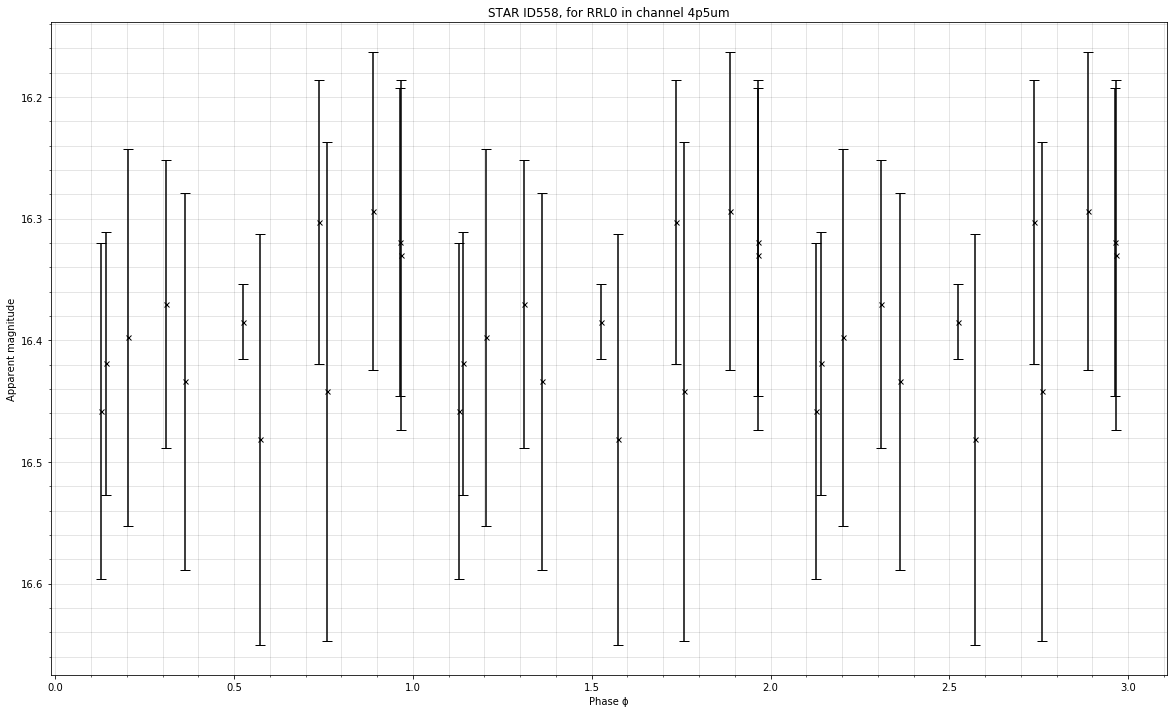

In [90]:
## LIGHT CURVE ANALYSIS: PAL5 3p6um DATA ##
##_______________________________________##

# OPTIONS
cluster_input = 'PAL5'
channel       = '4p5um'
epoch_path    = 'PAL5_data/*/'
main_file = 'C:/Users/lukeb/Documents/MPhys_Project_RRLs/Luke_RRLs_project/output_files/'+cluster_input+'_main_phot_'+channel+'.txt'
path1, path2 = epoch_path+cluster_input+'__e[0-9]_'+channel+'.fits', epoch_path+cluster_input+'__e[0-9][0-9]_'+channel+'.fits'
rrl = 0 # 0 to 4 for PAL5

def light_curve(cluster, channel, epoch_path, path1, path2, main_file, rrl):
    global main_table, lctime, P
    main_file = main_file
    main_table = ascii.read(main_file, delimiter = ',', data_start = 1)
    
    lctime = []
    
    for file in glob.glob(path1) + glob.glob(path2):
        with fits.open(file) as hdr_list:
            e_hdr = hdr_list[0].header
            lctime.append(Time(e_hdr['DATE_OBS'], format = 'isot', scale = 'utc').jd)
        
    rrl_cat = 'CCVS_data/CCVS_'+cluster+'_RRLs_data.txt'
    df_cat = ascii.read(rrl_cat, delimiter = ',', data_start = 1)
    
    df_cat['ra_deg'] = str('null')
    df_cat['dec_deg'] = str('null')
    
    for col in df_cat.itercols():
        if col.dtype.kind in 'SU':
            df_cat.replace_column(col.name, col.astype('object'))
            
    for i in range(len(df_cat)):
        ra_hms = Angle(df_cat['ra'][i], u.hour)
        df_cat['ra_deg'][i] = ra_hms.to_string(unit = u.deg, decimal = True)
    for i in range(len(df_cat)):
        dec_hms = Angle(df_cat['dec'][i], u.degree)
        df_cat['dec_deg'][i] = dec_hms.to_string(unit = u.deg, decimal = True)
        
    df_cat.write('CCVS_data/CCVS_{0}_RRLs_data_readin.txt'.format(cluster), format = 'csv', overwrite = True)
    
    cc_cat = pd.read_csv('CCVS_data/CCVS_'+cluster+'_RRLs_data_readin.txt', sep = ',', header = 0)
    coord_rrl = SkyCoord(cc_cat['ra_deg'], cc_cat['dec_deg'], unit = u.degree)
    coord_cat = SkyCoord(main_table['ra'], main_table['dec'], unit = u.degree)
    
    req_rrl = rrl
    c = coord_rrl[req_rrl]
    
    seps = []
    for i in range(len(coord_cat)):
        seps.append(coord_cat[i].separation(c).value)

    id_rrl = np.asarray(seps).argmin()
    
    P = cc_cat['period'][req_rrl]
    
    return id_rrl

id_rrl = light_curve(cluster_input, channel, epoch_path, path1, path2, main_file, rrl)

# EXTRACT MAGNITUDES AND UNCERTAINTIES
mag = []
mag_err = []

for i in range(1, 13):
    epoch = i
    mag.append(main_table[main_tableid]['mag_e'+str(i)])
    mag_err.append(main_table[main_tableid]['unc_e'+str(i)])
print(mag)
print(mag_err)
# CONVERT JD TO PHASE

phase = []

for i in lctime:
    func = i / P
    phase_val = func - np.floor(func)
    phase.append(phase_val)
print(phase)
mag = np.ma.array(mag)
mag = np.ma.masked_where(mag == -99, mag)
mag_err = np.ma.array(mag_err)
mag_err = np.ma.masked_where(mag_err == -99, mag_err)
phase = np.ma.masked_array(phase, mag.mask)
mag_long = np.concatenate((mag, mag, mag))
unc_long = np.concatenate((mag_err, mag_err, mag_err))
phase_long = np.concatenate((phase, phase + 1., phase + 2.))

plt.errorbar(x = phase_long, y = mag_long, xerr = None, yerr = unc_long, fmt = 'kx', markersize = 5, capsize = 5)
plt.xlabel('Phase ϕ')
plt.ylabel('Apparent magnitude')
plt.title('STAR ID{0}, for RRL{1} in channel {2}'.format(id_rrl, rrl, channel))
plt.minorticks_on()
plt.grid(b = True, which = 'major', lw = .5, alpha = .2, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, alpha = .2, color = 'black')
plt.gca().invert_yaxis()
plt.gcf().set_size_inches(20, 12)
plt.show()

C:/Users/lukeb/Documents/MPhys_Project_RRLs/Luke_RRLs_project/output_files/PAL5_main_phot_4p5um.txt
RRL 3: RA = 228.993, dec = -0.0965
[16.293903179408495, 16.458074464417347, 16.37022932874275, 16.384726767959535, 16.302742027069176, 16.319236517572133, 16.418846668293725, 16.43379825001023, 16.481433361153613, 16.441963957407122, 16.32985698767632, 16.397574818124003]
[0.1306825366025688, 0.13812491530660598, 0.11799226602698927, 0.030737953005680118, 0.11695302988316451, 0.12619658214631027, 0.10806463864718542, 0.15464900975249965, 0.16900464412889293, 0.2047338009610506, 0.14369093415965586, 0.1550731365212978]
[0.6012800723838154, 0.881053598393919, 0.09189723100280389, 0.34258906164905056, 0.5877600956591778, 0.8530971653526649, 0.05706261552404612, 0.31316417941707186, 0.5593829330755398, 0.7749495583120733, 0.015931547852233052, 0.2923763811995741]


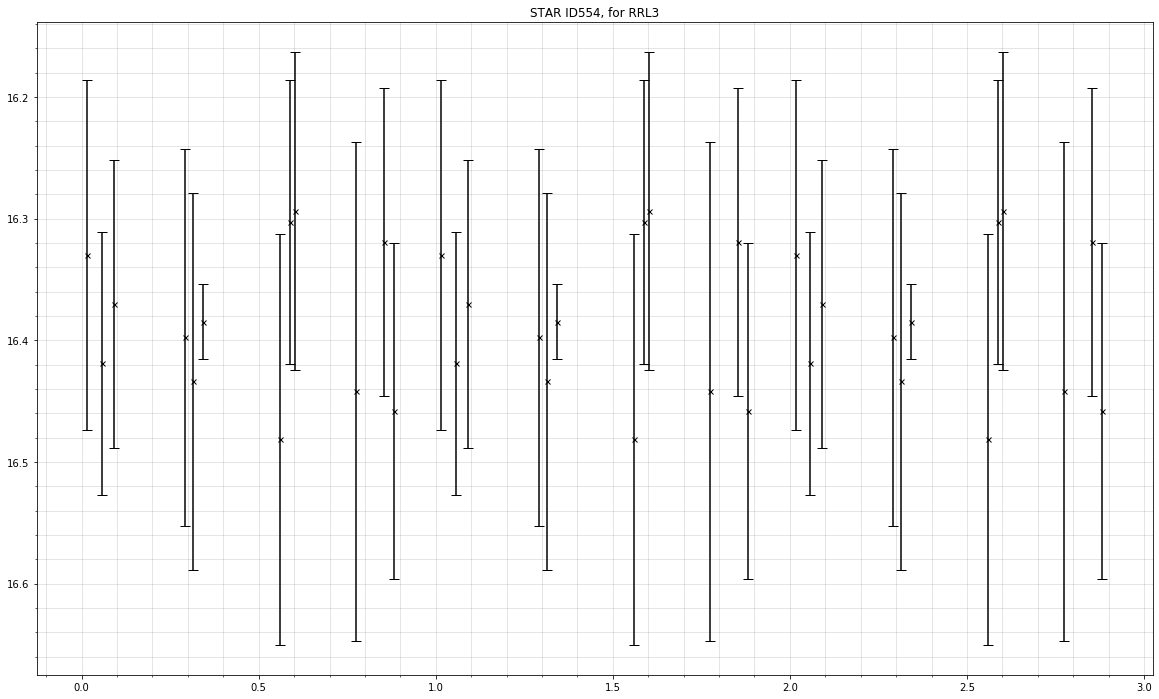

In [53]:
## LIGHT CURVE ANALYSIS: PAL5 3p6um DATA ##
##_______________________________________##

# OPTIONS
cluster_input = 'PAL5'
channel       = '3p6um'
epoch_path    = 'PAL5_data/*/'
    
## READ IN MAIN FILE ##

main_file = 'C:/Users/lukeb/Documents/MPhys_Project_RRLs/Luke_RRLs_project/output_files/'+cluster_input+'_main_phot_'+channel+'.txt'
main_table = ascii.read(main_file, delimiter = ',', data_start = 1)
print(main_file)
## EXTRACTING LCTIME ##

path1 = epoch_path+cluster_input+'__e[0-9]_'+channel+'.fits'
path2 = epoch_path+cluster_input+'__e[0-9][0-9]_'+channel+'.fits'

lctime = []

for file in glob.glob(path1, recursive = True) + glob.glob(path2, recursive = True):
    with fits.open(file) as hdr_list:
        e_hdr = hdr_list[0].header
        lctime.append(Time(e_hdr['DATE_OBS'], format = 'isot', scale = 'utc').mjd)
    
## BASIC METHOD ##
# CATALOGUE INPUT DATA 
RRL_id = 3
rahms_cat = Angle('15:15:58.23', u.hour)
dechms_cat = Angle('-00:05:47.4', u.degree)
P = 0.2524

# CONVERT TO DECIMAL
ra_cat = rahms_cat.to_string(unit = u.deg, decimal = True)
dec_cat = dechms_cat.to_string(unit = u.deg, decimal = True)
print('RRL {0}: RA = {1}, dec = {2}'.format(RRL_id, ra_cat, dec_cat))

# MANUALLY FINDING RRL
#main_tableid = 95
#main_tableid = 24
main_tableid = 554


# EXTRACT MAGNITUDES AND UNCERTAINTIES
mag = []
mag_err = []

for i in range(1, 13):
    epoch = i
    mag.append(main_table[main_tableid]['mag_e'+str(i)])
    mag_err.append(main_table[main_tableid]['unc_e'+str(i)])
print(mag)
print(mag_err)
# CONVERT JD TO PHASE

phase = []

for i in lctime:
    func = i / P
    phase_val = func - np.floor(func)
    phase.append(phase_val)
print(phase)
mag = np.ma.array(mag)
mag = np.ma.masked_where(mag == -99, mag)
mag_err = np.ma.array(mag_err)
mag_err = np.ma.masked_where(mag_err == -99, mag_err)
phase = np.ma.masked_array(phase, mag.mask)
mag_long = np.concatenate((mag, mag, mag))
unc_long = np.concatenate((mag_err, mag_err, mag_err))
phase_long = np.concatenate((phase, phase + 1., phase + 2.))

plt.errorbar(x = phase_long, y = mag_long, xerr = None, yerr = unc_long, fmt = 'kx', markersize = 5, capsize = 5)
#plt.xlabel['a']
#plt.ylabel['Apparent magnitude']
plt.title('STAR ID{0}, for RRL{1}'.format(main_tableid, RRL_id))
plt.minorticks_on()
plt.grid(b = True, which = 'major', lw = .5, alpha = .2, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, alpha = .2, color = 'black')
plt.gca().invert_yaxis()
plt.gcf().set_size_inches(20, 12)
plt.show()